# TODO:
[ ] Create widget and deploy

[ ] Get more examples of not-poison-oak

[x] Get better metric to track than accuracy (really care about maximizing recall, less about precision)

[ ] Clean data more

[ ] Maybe try data aug to make leaves different colors because some poison oak is green and some is red

# Imports and set Bing API Key

In [46]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *
from utils import *
from IPython.display import display
import shutil
key = 'bfe4c5c0c789435b9894b166b1ef6d6a'

In [47]:
# !pip install voila-material

# Process Data

## Load Data

In [2]:
path = Path('data'); path.ls()

(#2) [Path('data/leaves'),Path('data/poison-oak')]

In [19]:
def search_images_bing(key, term, count, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=count, min_height=min_sz, min_width=min_sz).value)

In [20]:
labels = ['poison-oak', 'leaves']
counts = [150, 450]
for label, count in zip(labels, counts):
    os.makedirs(path/label, exist_ok=True)
    res = search_images_bing(key, label, count=count)
    download_images(path/label, urls=res.attrgot('content_url'))


 Download of http://www.splintercat.org/PortlandHikers/PoisonOak02.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p data/poison-oak
$ cd data/poison-oak
$ wget -c http://www.splintercat.org/PortlandHikers/PoisonOak02.jpg
$ tar xf PoisonOak02.jpg
 And re-run your code once the download is successful



In [21]:
(path/labels[0]).ls(), (path/labels[1]).ls()

((#148) [Path('data/poison-oak/00000003.jpg'),Path('data/poison-oak/00000001.jpg'),Path('data/poison-oak/00000007.jpg'),Path('data/poison-oak/00000005.jpg'),Path('data/poison-oak/00000009.jpg'),Path('data/poison-oak/00000006.jpg'),Path('data/poison-oak/00000008.png'),Path('data/poison-oak/00000012.jpg'),Path('data/poison-oak/00000010.jpg'),Path('data/poison-oak/00000013.jpg')...],
 (#175) [Path('data/leaves/00000006.jpg'),Path('data/leaves/00000005.JPG'),Path('data/leaves/00000008.jpg'),Path('data/leaves/00000007.jpeg'),Path('data/leaves/00000002.jpg'),Path('data/leaves/00000010.jpg'),Path('data/leaves/00000003.jpg'),Path('data/leaves/00000011.jpg'),Path('data/leaves/00000001.jpg'),Path('data/leaves/00000012.JPG')...])

## Verify images

In [124]:
verify_images(get_image_files(path))[-5:]

(#0) []

In [25]:
bad = verify_images(get_image_files(path))
print(bad)
for img in bad: img.unlink()

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#6) [Path('data/poison-oak/00000014.jpg'),Path('data/poison-oak/00000020.jpg'),Path('data/poison-oak/00000028.jpg'),Path('data/poison-oak/00000073.png'),Path('data/poison-oak/00000140.jpg'),Path('data/leaves/00000043.png')]


In [26]:
(path/'poison-oak').ls(), (path/'leaves').ls()

((#143) [Path('data/poison-oak/00000003.jpg'),Path('data/poison-oak/00000001.jpg'),Path('data/poison-oak/00000007.jpg'),Path('data/poison-oak/00000005.jpg'),Path('data/poison-oak/00000009.jpg'),Path('data/poison-oak/00000006.jpg'),Path('data/poison-oak/00000008.png'),Path('data/poison-oak/00000012.jpg'),Path('data/poison-oak/00000010.jpg'),Path('data/poison-oak/00000013.jpg')...],
 (#174) [Path('data/leaves/00000006.jpg'),Path('data/leaves/00000005.JPG'),Path('data/leaves/00000008.jpg'),Path('data/leaves/00000007.jpeg'),Path('data/leaves/00000002.jpg'),Path('data/leaves/00000010.jpg'),Path('data/leaves/00000003.jpg'),Path('data/leaves/00000011.jpg'),Path('data/leaves/00000001.jpg'),Path('data/leaves/00000012.JPG')...])

## Create DataBlock

In [126]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 get_y=parent_label,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42))

## Apply data augmentation

In [133]:
aug_data = data.new(item_tfms=RandomResizedCrop(224), batch_tfms=aug_transforms())

## Create dataloader

In [134]:
dls = aug_data.dataloaders(path, bs=64)

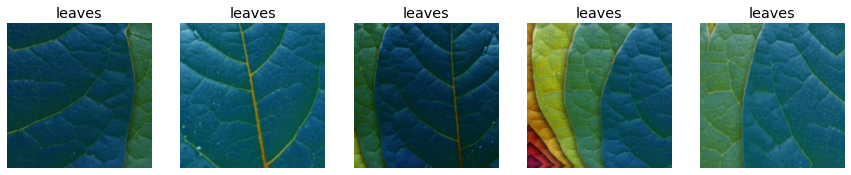

In [135]:
dls.show_batch(max_n=5, nrows=1, unique=True)

## Look at batch

In [136]:
xb, yb = first(dls.valid)

In [137]:
xb.shape, yb.shape

(torch.Size([61, 3, 224, 224]), torch.Size([61]))

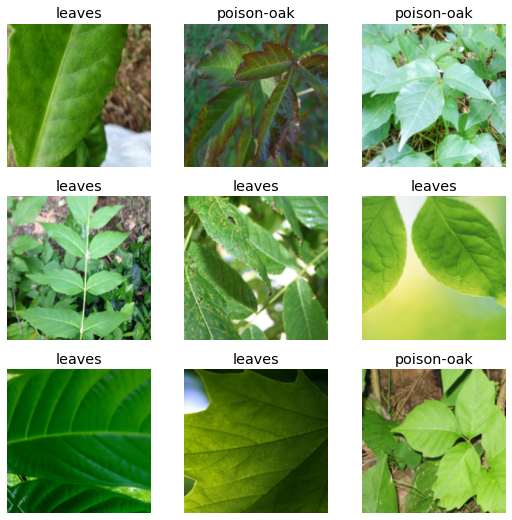

In [138]:
dls.show_batch(max_n=9, figsize=(9, 9))

In [139]:
len(dls.train_ds), len(dls.valid_ds)

(245, 61)

# Modeling

## Create Model

In [148]:
learn = cnn_learner(dls, resnet50, metrics=[accuracy, Recall(), Precision()])

## Train model

In [149]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,1.168798,3.013219,0.491803,1.000000,0.491803,00:13


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.602478,1.739036,0.557377,1.000000,0.526316,00:12
1,0.662204,0.903144,0.655738,1.000000,0.588235,00:12
2,0.560692,1.002646,0.704918,1.000000,0.625000,00:13
3,0.496078,0.545251,0.868852,1.000000,0.789474,00:12
4,0.477726,0.438359,0.836066,0.900000,0.794118,00:13
5,0.457381,0.416752,0.852459,0.900000,0.818182,00:13


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

# Analysis

In [150]:
interp = ClassificationInterpretation.from_learner(learn)

## Plot results 

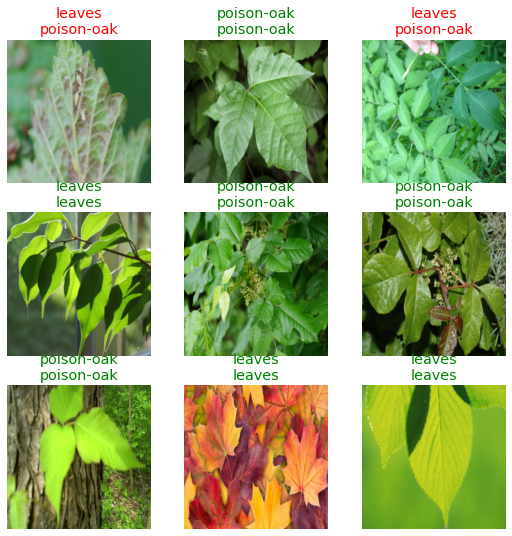

In [151]:
learn.show_results(max_n=9, figsize=(9, 9))

## Confusion matrix

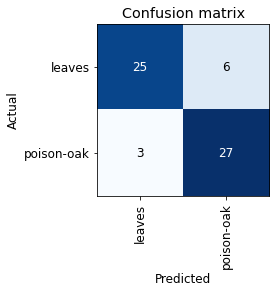

In [152]:
interp.plot_confusion_matrix()

## Top Losses

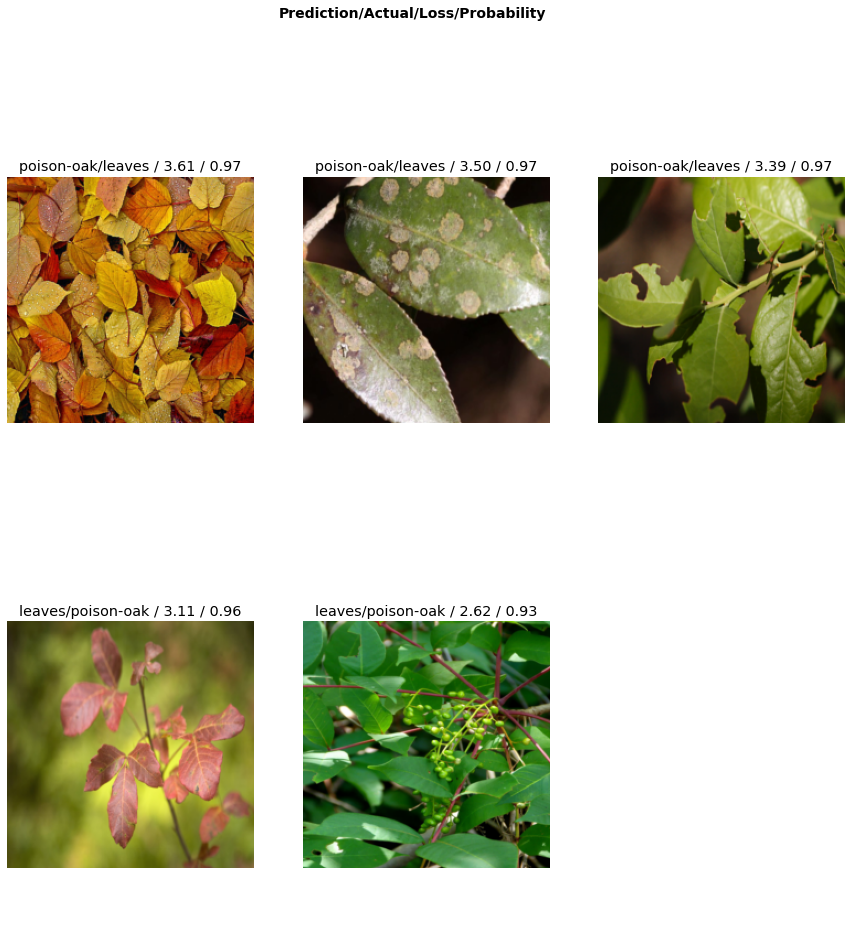

In [153]:
interp.plot_top_losses(5, figsize=(15, 15))

# Clean Dataset

## Image Cleaner widget

In [66]:
cleaner = ImageClassifierCleaner(learn, height=256)

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [67]:
cleaner

Make sure to delete/relabel images before moving onto next class / dataset. Image cleaner's tracking resets!

## Delete images

In [107]:
cleaner.delete()

(#2) [0,11]

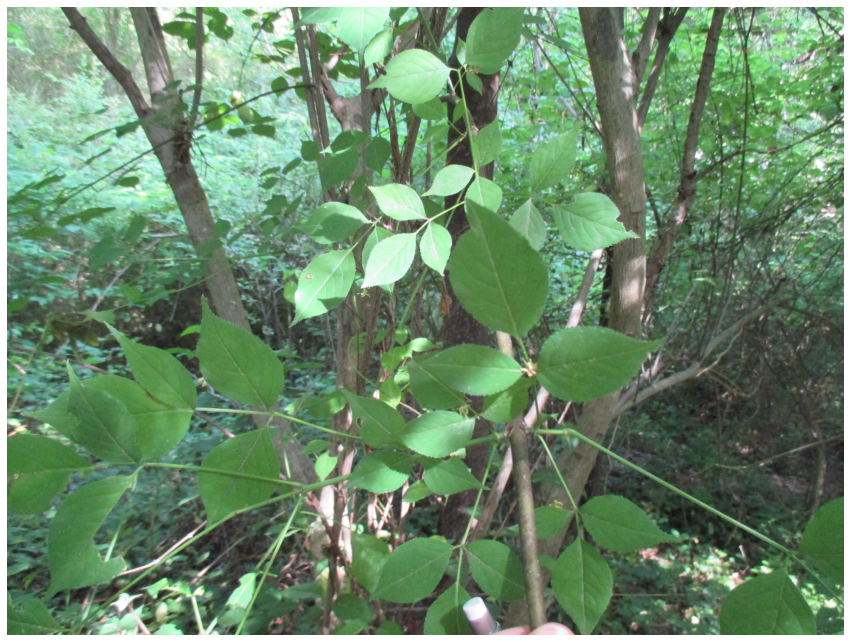

In [93]:
PILImage.create(cleaner.fns[3]).show(figsize=(15, 15))

In [108]:
for i in cleaner.delete(): cleaner.fns[i].unlink()

## Relabel images

In [119]:
cleaner.change(), cleaner.fns[14]

((#1) [(14, 'leaves')], Path('data/poison-oak/00000144.jpg'))

In [120]:
for i, new_lbl in cleaner.change(): shutil.move(str(cleaner.fns[i]), path/new_lbl/'relabeled.jpg')

# Inference

In [155]:
# Save model
learn.export()

In [156]:
# Load model for inference
model_inf = load_learner('export.pkl')

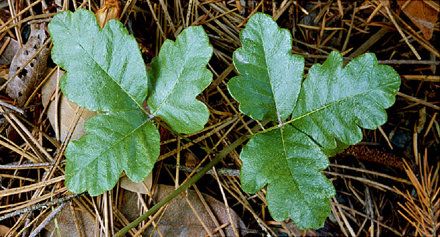

In [56]:
img = PILImage.create('poison-oak.jpg')
img.to_thumb(440)

In [60]:
model_inf.predict(img)

('poison-oak', tensor(1), tensor([0.1783, 0.8217]))

# Build Web App

In [117]:
uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [118]:
img = PILImage.create(uploader.data[0])
img.to_thumb(192)

IndexError: list index out of range

In [119]:
lbl = Label()

In [120]:
output = Output()
with output: display(img.to_thumb(412))
output

Output()

In [121]:
button = Button(description='Classify!')
button

Button(description='Classify!', style=ButtonStyle())

In [122]:
model_inf.dls.vocab

(#2) ['leaves','poison-oak']

In [123]:
def on_click(click):
    output.clear_output()
    img = PILImage.create(uploader.data[-1])
    pred, idx, probs = model_inf.predict(img)
    with output: display(img.to_thumb(200))
    
    # Correct leaves label to be more specific
    pred = 'not poison oak' if pred == 'leaves' else pred
    lbl.value = f'This is {pred} with probability: {probs[idx]*100:0.0f}%.'

In [124]:
button.on_click(on_click)

In [154]:
VBox([Label('See if a leaf is poison oak or not! :D'), uploader, button, output, lbl])